In [2]:
from pathlib import Path
import torch
import numpy as np
import random
from data import sample_latents
from vis import *
from models import *

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
dev = torch.device(dev)

In [3]:
D = [5, 5]
M = [[64, 64, 3], [64, 64, 3]]

z = sample_latents(D, "random", n_samples=10000)
z = scale_latents(z)

phi = ParallelSlots([SpriteworldRenderer(d_in, d_out) for d_in, d_out in zip(D, M)])
C = OccludeAdd()
f = CompositionalFunction(C, phi).to(dev)
f.eval()

CompositionalFunction(
  (composition): OccludeAdd()
  (slots): ParallelSlots(
    (slot_functions): ModuleList(
      (0-1): 2 x SpriteworldRenderer()
    )
  )
)

In [4]:
phi_hat = ParallelSlots([UpsampleMLP(d_in, d_out) for d_in, d_out in zip(D, M)])
C_hat = OccludeAdd(add="sigmoid")
f_hat = CompositionalFunction(C_hat, phi_hat).to(dev)

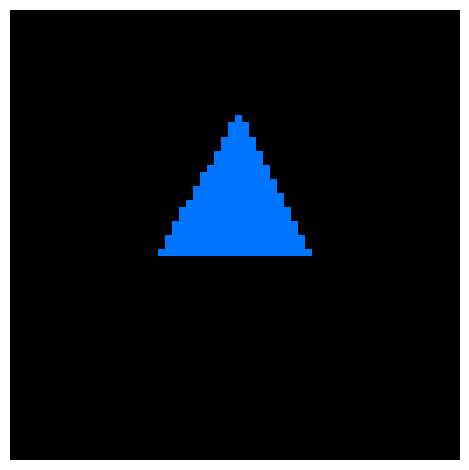

In [34]:
z = torch.Tensor([0.55, 0.8, 0.5, 1, 0.05, 0.5, 0.6, 0, 1, 0.6]).unsqueeze(0)
z = scale_latents(z)
with torch.no_grad():
    x, slots = f(z.to(dev), return_slot_outputs=True)
    x = x.squeeze().cpu()
    slots = [slot.squeeze().cpu() for slot in slots]

plt.imshow(slots[1])
plt.axis("off")
plt.tight_layout()
plt.savefig("/mnt/c/Users/thadd/OneDrive/Dokumente/PhD/projects/COOD/sample.png", format="svg", bbox_inches="tight")

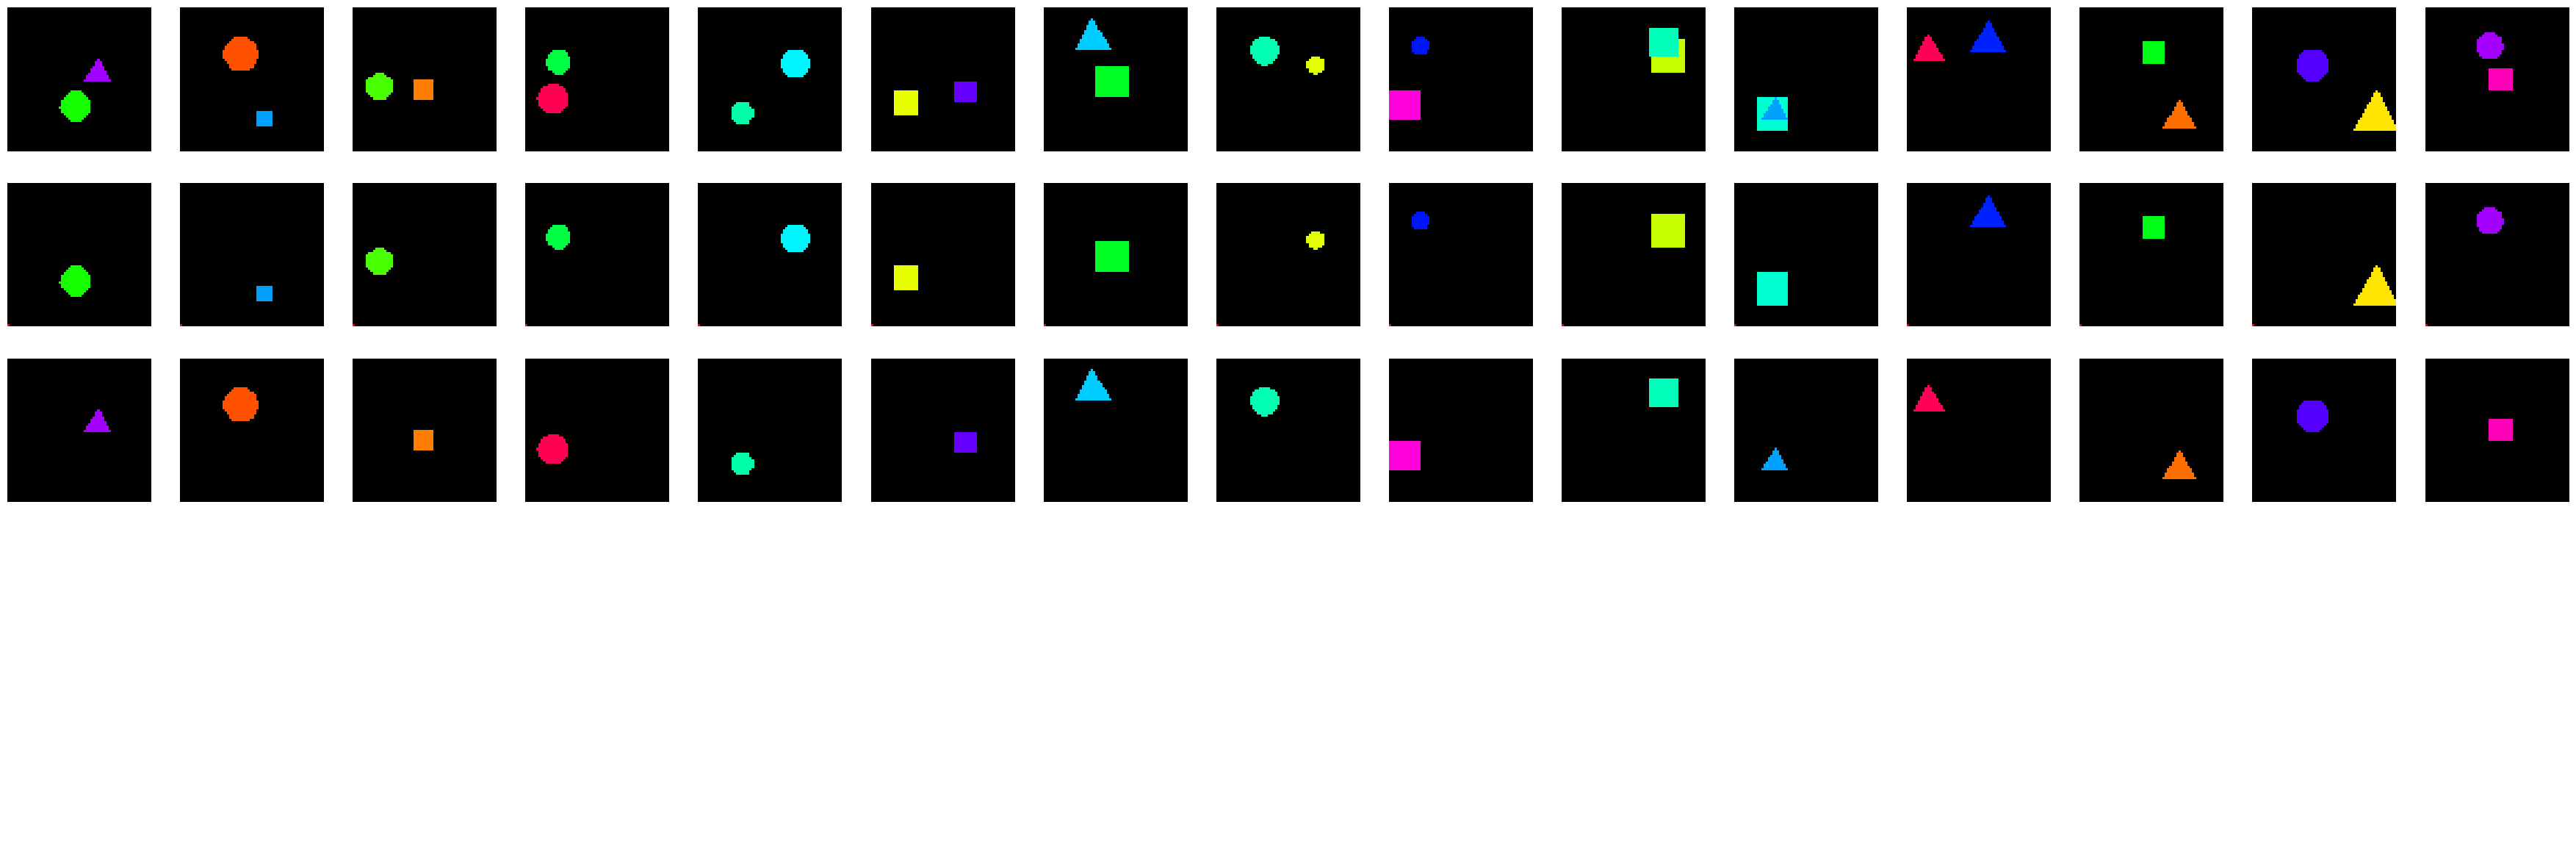

In [11]:
fig, axs = plt.subplots(6, 15, figsize=(15*3, 6*3))
[ax.axis("off") for ax in axs.ravel()]

for col, _z in enumerate(z[:15]):
    # target
    axs[0, col].imshow(f(_z.to(dev)).cpu().squeeze())

    # supports
    _z1 = torch.cat([torch.Tensor([0, 0, 0, 0, 0]), _z[5:]])
    _z2 = torch.cat([_z[:5], torch.Tensor([1, 1, 1, 0, 1])])
    axs[1, col].imshow(f(_z1.to(dev)).cpu().squeeze())
    axs[2, col].imshow(f(_z2.to(dev)).cpu().squeeze())

    # reconstructions
